Generate a PNG of binned (0.1 m/z) raw data for a single frame

In [41]:
import sqlite3
import pandas as pd
import numpy as np
import sys

In [42]:
RT_LIMIT_LOWER = 4340
RT_LIMIT_UPPER = 4580

In [43]:
MS1_CE = 10

In [221]:
# BASE_NAME = "/home/ubuntu/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
BASE_NAME = "/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
# ALLPEPTIDES_FILENAME = '/home/ubuntu/maxquant_results/txt/allPeptides.txt'
ALLPEPTIDES_FILENAME = '/Users/darylwilding-mcbride/Downloads/maxquant_results/txt/allPeptides.txt'

CONVERTED_DATABASE_NAME = '{}/HeLa_20KInt.sqlite'.format(BASE_NAME)

In [222]:
CONVERTED_DATABASE_NAME

'/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-4340-4580/HeLa_20KInt.sqlite'

In [46]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy == {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER,MS1_CE), db_conn)
db_conn.close()

In [47]:
df.head()

,frame_id,retention_time_secs
0,40411,4340.340330
1,40422,4341.521415
2,40433,4342.702923
3,40444,4343.883324
4,40455,4345.067491


In [69]:
RAW_FRAME_ID = 40444
RAW_FRAME_RT = df[df.frame_id == RAW_FRAME_ID].retention_time_secs.values[0]

In [252]:
MZ_MIN = 100.0
MZ_MAX = 1700.0
MZ_BIN_WIDTH = 0.1
MZ_BINS = int((MZ_MAX-MZ_MIN)/MZ_BIN_WIDTH)
SCAN_MIN = 1
SCAN_MAX = 910

In [210]:
MZ_BINS

16000

Populate the intensity array with points from the raw frame

In [53]:
# load the raw frame points
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_points_df = pd.read_sql_query("select mz,scan,intensity from frames where frame_id == {}".format(RAW_FRAME_ID), db_conn)
db_conn.close()

In [54]:
raw_points_df.intensity.max()

11145

In [55]:
len(raw_points_df)

256539

In [165]:
intensity_array = np.zeros([SCAN_MAX, MZ_BINS], dtype=np.uint16)  # scratchpad for the intensity value prior to image conversion
for point_idx in range(len(raw_points_df)):
    point_df = raw_points_df.iloc[point_idx]
    mz = point_df.mz
    scan = int(point_df.scan)
    if (mz >= MZ_MIN) and (mz <= MZ_MAX) and (scan >= SCAN_MIN) and (scan <= SCAN_MAX):
        mz_array_idx = int((mz-MZ_MIN)/MZ_BIN_WIDTH)+1
        scan_array_idx = scan
        intensity = int(point_df.intensity)
        intensity_array[scan_array_idx,mz_array_idx] += intensity

In [166]:
intensity_array.max()

13171

In [167]:
DELTA_MZ = 1.003355     # Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.

In [168]:
MZ_TOLERANCE_PPM = 5
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4

In [169]:
round(2.3456788,1)

2.3

In [170]:
import decimal

In [171]:
abs(decimal.Decimal("{}".format(MZ_BIN_WIDTH)).as_tuple().exponent)

1

In [172]:
MZ_BIN_WIDTH

0.1

there are 330 MQ features overlapping this frame


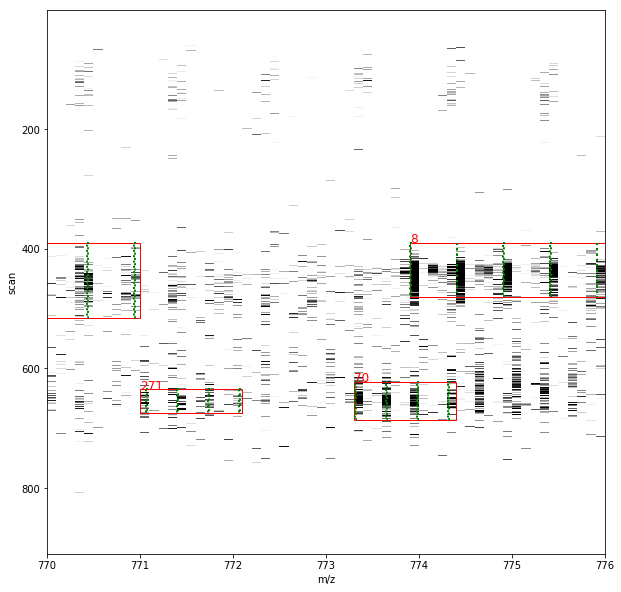

In [338]:
# overlay the image with MQ feature locations
import matplotlib.patches as patches
from matplotlib import colors, cm, pyplot as plt

mz_actual_lower = 770
mz_actual_upper = 776

mz_idx_lower = int((mz_actual_lower-MZ_MIN)/MZ_BIN_WIDTH)+1
mz_idx_upper = int((mz_actual_upper-MZ_MIN)/MZ_BIN_WIDTH)+1

scan_lower = 1
scan_upper = 910

f, ax1 = plt.subplots()

f.set_figheight(10)
f.set_figwidth(10)

plt.xlabel('m/z')
plt.ylabel('scan')
plt.margins(0.06)

MIN_ISOTOPE_CORRELATION = 0.9

allpeptides_df = pd.read_csv(ALLPEPTIDES_FILENAME, sep='\t')
allpeptides_df.rename(columns={'Number of isotopic peaks':'isotope_count', 'm/z':'mz', 'Number of data points':'number_data_points', 'Intensity':'intensity', 'Ion mobility index':'scan', 'Ion mobility index length':'scan_length', 'Ion mobility index length (FWHM)':'scan_length_fwhm', 'Retention time':'rt', 'Retention length':'rt_length', 'Retention length (FWHM)':'rt_length_fwhm', 'Charge':'charge_state', 'Number of pasef MS/MS':'number_pasef_ms2_ids', 'Isotope correlation':'isotope_correlation'}, inplace=True)

# use the feature's FWHM in RT
allpeptides_df["rt_delta"] = allpeptides_df.rt_length_fwhm / 2
allpeptides_df["rt_lower"] = allpeptides_df.rt - allpeptides_df.rt_delta
allpeptides_df["rt_upper"] = allpeptides_df.rt + allpeptides_df.rt_delta

# use the features that were found (not just identified) if their isotope correlation was more than MIN_ISOTOPE_CORRELATION
allpeptides_subset_df = allpeptides_df[(allpeptides_df.intensity.notnull()) & (allpeptides_df.rt_lower <= RAW_FRAME_RT) & (allpeptides_df.rt_upper >= RAW_FRAME_RT) & (allpeptides_df.isotope_correlation >= MIN_ISOTOPE_CORRELATION)].copy()
print("there are {} MQ features overlapping this frame".format(len(allpeptides_subset_df)))

# sort the MQ features by decreasing intensity and give them an ID
allpeptides_subset_df.sort_values(by=['intensity'], ascending=False, inplace=True)
allpeptides_subset_df["mq_feature_id"] = np.arange(start=1, stop=len(allpeptides_subset_df)+1)

# show the image
cmap = cm.get_cmap('gist_yarg')
cmap_value_lower = 1
cmap_value_upper = 150
ax1.imshow(intensity_array[scan_lower:scan_upper,mz_idx_lower:mz_idx_upper], cmap=cmap, norm=colors.Normalize(vmin=cmap_value_lower, vmax=cmap_value_upper, clip=True), interpolation='none', aspect='auto', extent=[mz_actual_lower,mz_actual_upper,scan_upper,scan_lower])

binned_mz_idx_lower = []
binned_mz_idx_upper = []
binned_scan_idx_lower = []
binned_scan_idx_upper = []

# overlay the MQ feature rectangles
for mq_feature_idx in range(len(allpeptides_subset_df)):
    mq_feature_df = allpeptides_subset_df.iloc[mq_feature_idx]
    df_idx = mq_feature_df.index
    mq_feature_id = int(mq_feature_df.mq_feature_id)

    charge_state = int(mq_feature_df.charge_state)
    isotope_count = int(mq_feature_df.isotope_count)

    expected_isotope_spacing_mz = DELTA_MZ / charge_state

    # determine the bounding box coordinates for m/z and scan in real space
    mq_feature_mz = mq_feature_df.mz
    mz_delta = mq_feature_mz * MZ_TOLERANCE_PERCENT / 100
    rect_mz_lower = int(mq_feature_mz / MZ_BIN_WIDTH) * MZ_BIN_WIDTH
    rect_mz_upper = int((mq_feature_mz + ((isotope_count-1) * expected_isotope_spacing_mz)) / MZ_BIN_WIDTH) * MZ_BIN_WIDTH + MZ_BIN_WIDTH
    rect_mz_range = rect_mz_upper - rect_mz_lower
    binned_mz_idx_lower.append(int((rect_mz_lower-MZ_MIN)/MZ_BIN_WIDTH)+1)
    binned_mz_idx_upper.append(int((rect_mz_upper-MZ_MIN)/MZ_BIN_WIDTH)+1)

    rect_scan = mq_feature_df.scan
    rect_scan_delta = int(mq_feature_df.scan_length / 2)
    rect_scan_lower = rect_scan - rect_scan_delta
    rect_scan_upper = rect_scan + rect_scan_delta
    rect_scan_range = int(mq_feature_df.scan_length)
    binned_scan_idx_lower.append(rect_scan_lower)
    binned_scan_idx_upper.append(rect_scan_upper)
    
    # draw the rectangle for the feature's extent
    mq_feature_rect = patches.Rectangle((rect_mz_lower,rect_scan_lower),rect_mz_range,rect_scan_range,linewidth=1,linestyle='-',edgecolor='r',facecolor='none', label='feature')
    ax1.add_patch(mq_feature_rect)

    # draw the isotopes
    isotope_base_mz_lower = mq_feature_mz - mz_delta
    isotope_base_mz_upper = mq_feature_mz + mz_delta
    for isotope_idx in range(0,isotope_count):
        isotope_mz_lower = isotope_base_mz_lower + (isotope_idx * expected_isotope_spacing_mz)
        isotope_mz_upper = isotope_base_mz_upper + (isotope_idx * expected_isotope_spacing_mz)
        isotope_rect = patches.Rectangle((isotope_mz_lower,rect_scan_lower),isotope_mz_upper-isotope_mz_lower,rect_scan_range,linewidth=2,linestyle=':',edgecolor='g',facecolor='none', label='isotope')
        ax1.add_patch(isotope_rect)
    
    # draw the feature label
    text_style = dict(size=12, color='red')
    text_x = rect_mz_lower
    text_y = rect_scan_lower-0.5
    if (text_x >= mz_actual_lower) and (text_x <= mz_actual_upper) and (text_y >= scan_lower) and (text_y <= scan_upper):
        ax1.text(text_x, text_y, "{}".format(mq_feature_id), **text_style)

allpeptides_subset_df['binned_rect_mz_idx_lower'] = binned_mz_idx_lower
allpeptides_subset_df['binned_rect_mz_idx_upper'] = binned_mz_idx_upper
allpeptides_subset_df['binned_rect_scan_idx_lower'] = binned_scan_idx_lower
allpeptides_subset_df['binned_rect_scan_idx_upper'] = binned_scan_idx_upper


In [315]:
allpeptides_subset_df.head()

,Raw file,charge_state,mz,Mass,Resolution,number_data_points,Number of frames,isotope_count,isotope_correlation,Mass fractional part,...,Pasef MS/MS IDs,MS/MS scan number,rt_delta,rt_lower,rt_upper,mq_feature_id,binned_rect_mz_lower,binned_rect_mz_upper,binned_rect_scan_lower,binned_rect_scan_upper
235967,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,781.34758,1560.6806,23857.587411,89302,62,6,0.999515,0.680615,...,312782;314090;314276;314489;316524;316575;316889,56573.0,4.1330,4337.3880,4345.6540,1,781.3,783.9,383,547
278902,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,869.08526,2604.2340,24318.013641,67934,23,6,0.997396,0.233963,...,312923;312974;312986;313010;313022;313163;3132...,96070.0,4.7285,4341.5215,4350.9785,2,869.0,870.8,344,604
267086,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,855.43633,1708.8581,23938.058772,77224,44,13,0.969803,0.858111,...,312343;312354;312365;312453;312475;312487;3125...,66473.0,4.1350,4338.5680,4346.8380,3,855.4,861.5,305,457
270797,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,877.49010,1752.9657,24805.046260,13196,14,6,0.999118,0.965651,...,312934;312947;313044;313149,69096.0,2.9545,4343.2955,4349.2045,4,877.4,880.0,323,451
217119,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,739.37134,1476.7281,23987.533743,23594,33,4,0.998484,0.728123,...,312124;312136;312835;313035;313047;314519,50353.0,3.5455,4341.5215,4348.6125,5,739.3,740.9,458,574


In [ ]:
PIXELS_PER_MZ_BIN = 5
PIXELS_PER_SCAN = 1

In [254]:
# will stretch the image to these dimensions
IMAGE_HEIGHT = SCAN_MAX
IMAGE_WIDTH = IMAGE_HEIGHT

In [322]:
PIXELS_X = MZ_BINS * PIXELS_PER_MZ_BIN
PIXELS_Y = SCAN_MAX * PIXELS_PER_SCAN
MZ_BINS_PER_IMAGE = int(IMAGE_WIDTH / PIXELS_PER_MZ_BIN)
IMAGES_PER_FRAME = int(MZ_BINS / MZ_BINS_PER_IMAGE)
RESIZE_FACTOR_X = IMAGE_WIDTH / MZ_BINS_PER_IMAGE


In [323]:
RESIZE_FACTOR_X

5.0

In [276]:
MZ_BINS_PER_IMAGE

182

In [277]:
IMAGES_PER_FRAME

87

In [237]:
# convert the intensity array to an image
df = pd.DataFrame(intensity_array).stack().rename_axis(['y', 'x']).reset_index(name='intensity')

In [238]:
# remove all the zero-intensity elements
df = df[df.intensity > 0]

In [239]:
len(df)

229382

In [240]:
df.head()

,y,x,intensity
551069,34,7069,11
552023,34,8023,9
561241,35,1241,9
583785,36,7785,13
600560,37,8560,9


In [241]:
norm=colors.Normalize(vmin=cmap_value_lower, vmax=cmap_value_upper, clip=True)
cmap = cm.get_cmap('gist_yarg')
print(cmap(norm(100), bytes=True))

(85, 85, 85, 255)


In [269]:
def convert_to_colour(intensity):
    return cmap(norm(intensity), bytes=True)[:3]

In [271]:
df['colour'] = df.apply(lambda x: convert_to_colour(x.intensity), axis=1)

In [272]:
df.head()

,y,x,intensity,colour
551069,34,7069,11,"(238, 238, 238)"
552023,34,8023,9,"(242, 242, 242)"
561241,35,1241,9,"(242, 242, 242)"
583785,36,7785,13,"(235, 235, 235)"
600560,37,8560,9,"(242, 242, 242)"


In [302]:
im_array = np.zeros([IMAGE_HEIGHT, MZ_BINS, 3], dtype=np.uint8)  # container for the image
im_array[:] = 255 # fill it

In [303]:
for idx in range(len(df)):
    row = df.iloc[idx]
    x = int(row.x)
    y = int(row.y)
    c = row.colour
    im_array[y,x,:] = c

In [336]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

for image_idx in range(IMAGES_PER_FRAME):
    # image m/z coordinates
    image_base_mz = int((image_idx * MZ_BINS_PER_IMAGE * MZ_BIN_WIDTH) + MZ_MIN)
    image_width_mz = int(MZ_BINS_PER_IMAGE * MZ_BIN_WIDTH)
    # image index coordinates
    image_idx_base = int(image_idx * MZ_BINS_PER_IMAGE)
    image_idx_width = MZ_BINS_PER_IMAGE
    # extract the subset of the frame for this image
    im_subset = im_array[:,image_idx_base:image_idx_base+image_idx_width,:]
    image = Image.fromarray(im_subset, 'RGB')
    image_with_overlay = Image.fromarray(im_subset, 'RGB')
    
    # stretch the image to be square
    stretched_image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    stretched_image_with_overlay = image_with_overlay.resize((IMAGE_WIDTH, IMAGE_HEIGHT))

    # get the MQ features that fully fit in the tile
    for mq_feature_idx in range(len(allpeptides_subset_df)):
        mq_feature_df = allpeptides_subset_df.iloc[mq_feature_idx]
        mq_feature_id = int(mq_feature_df.mq_feature_id)
        mq_feature_mz = mq_feature_df.mz

        # draw the MQ features overlay
        draw = ImageDraw.Draw(stretched_image_with_overlay)
        x0 = (mq_feature_df.binned_rect_mz_idx_lower - image_idx_base) * RESIZE_FACTOR_X
        x1 = (mq_feature_df.binned_rect_mz_idx_upper - image_idx_base) * RESIZE_FACTOR_X
        y0 = mq_feature_df.binned_rect_scan_idx_lower
        y1 = mq_feature_df.binned_rect_scan_idx_upper
        # draw the MQ feature if it overlaps at all with the image
        if ((x0 >= 0) and (x0 <= IMAGE_WIDTH)) or ((x1 >= 0) and (x1 <= IMAGE_WIDTH)):
            draw.rectangle(xy=[(x0, y0), (x1, y1)], fill=None, outline='red')
            draw.text((x0, y0-12), "{}".format(mq_feature_id), font=ImageFont.truetype('/Library/Fonts/Arial.ttf', 12), fill='red')

    # write them out
    IMAGE_BASE = '/Users/darylwilding-mcbride/Downloads/yolo-train'
    train_filename = '{}/test-{}-mz-{}-{}.png'.format(IMAGE_BASE, image_idx, image_base_mz, image_base_mz+image_width_mz)
    overlay_filename = '{}/overlay/test-{}-mz-{}-{}.png'.format(IMAGE_BASE, image_idx, image_base_mz, image_base_mz+image_width_mz)
    stretched_image.save(train_filename)
    stretched_image_with_overlay.save(overlay_filename)

    